# Test notebook to develop H-alpha activity metric and store to L2 data.
 

## Out line of how to put this notebook together:
 - Document the process here: https://exoplanets.atlassian.net/wiki/spaces/shrek/pages/2523398156/Activity+indicators
 - From Robertson 2013: IHα =  FHα / (F1+F2) is the sum of the flux in a band of width 1.6 Ang centered on the Hα λ6562.828 Ang line. [−700 km s−1, −300 km s−1] (from the Hα line center) for band 1 and [600 km s−1, 1000 km s−1] for band 2,
 
 - Start with NEID. The KPF data is not ready for this yet.
 - Identify the data extension and the wavelength extension 
 - Open the file, identify the order and wavelengths to use. (done)
 - Choose the H-alpha line plot them

 - Extract the BC and systemic RV from the header (NEID, L1 data has these) (Can't find the systemic RV)
 - Continuum normalize the single order.  (done)
     - Use the method that utilizes the order itself.
     - Use Fei's method, copy that code directly here.
 - Identify the pixels to use. (done)
 - Shift the spectrum onto th Earth reference wavelengths (ie rest wavelength). (done - roughly, need header value)
 - Check for cosmic rays (remove extremely high flux outliers in either the core or reference bands.
 - Sum flux of core, continuum1, continuum2. (done)
 - Calculate F_H-alpha, I_H-alpha (Robertson 2013, equation 1). (done)
 - Calculate sigma_F(H_alpha) (Robertson 2013, in between eqn 1 and 2).
 - Create nice plot that displays the core, continuum sections and annotates the plot. (done)
 - Check that the F_H-alpha numbers make sense, by checking the R2013 table. (roughly yes)
 - Save the fluxes and errors in the header, and write out a temp file.
  

In [2]:
# Standard dependencies  (copied from the bias module)
import configparser
import numpy as np
from scipy.ndimage.interpolation import shift
from astropy.io import fits
from astropy.constants import c
from astropy.io.fits import Column
from numpy.polynomial import legendre

# Pipeline dependencies
#from kpfpipe.logger import start_logger
#from kpfpipe.primitives.level0 import KPF0_Primitive
#from kpfpipe.models.level1 import KPF1

# External dependencies
#from keckdrpframework.models.action import Action
#from keckdrpframework.models.arguments import Arguments
#from keckdrpframework.models.processing_context import ProcessingContext

# Above are copied from bias, below are new
#from kpfpipe.models.level1 import KPF1
import os
TEST_DIR = os.getenv('KPFPIPE_TEST_DATA')
from astropy.io import fits
from astropy import constants
from matplotlib import pyplot as plt

from astropy import units as u
from scipy.interpolate import splev, splrep
from scipy import interpolate
# Plotting parameters
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams.update({'font.size': 20})

In [3]:
# NEID config details. Configuration from Robertson (2013)
Halpha_wavelength = 6562.828 # Ang: Robertson (2013)
Halpha_width = 1.6 # Angstroms from line center
Halpha_order =  80 # NEID
npix         = 9216 # pixels per order



# Same for both NEID and KPF
cont_v1a = -700 # velocity km/s from line center 
cont_v1b = -300 # for beg and end of each continuum section
cont_v2a =  600
cont_v2b = 1000
c_kmps = constants.c.to_value() /1000. * u.km / u.second 
Hwid_v1a = Halpha_wavelength - (Halpha_width/2.) # same for N/K
Hwid_v1b = Halpha_wavelength + (Halpha_width/2.)


In [4]:
# Development cell
# Start with opening the NEID File, 
in_file = '/NEIDdata/TAUCETI_20191217/L2/neidL2_20191217T023129.fits'# H-alpha in order 77 and no proper wave soln
in_file = '/NEIDdata/TAUCETI/L2/neidL2_20210714T063111.fits' # Has proper wavelength solution.
# Open L2 data.
print(TEST_DIR + in_file)
with fits.open(TEST_DIR + in_file) as hdul2:
    sci_flux = hdul2['SCIFLUX'].data
    sci_wave = hdul2['SCIWAVE'].data # dimensions are reversed
    cal_wave = hdul2['CALWAVE'].data # Not populated.
    head = hdul2[0].header
    sci_wave_hd = hdul2['SCIWAVE'].header
    cal_wave_hd = hdul2['CALWAVE'].header
    activity_hd = hdul2['ACTIVITY'].header
    activity_data = hdul2['ACTIVITY'].data
    print("type:",type(hdul2['ACTIVITY'].data))
    hdul2.info()        
sci_wave[0,:].size
print(repr(sci_wave_hd))
#6527.0358 order 80

/data/NEIDdata/TAUCETI/L2/neidL2_20210714T063111.fits
type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
Filename: /data/NEIDdata/TAUCETI/L2/neidL2_20210714T063111.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     746   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      

In [7]:
print(repr(head))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CHECKSUM= 'TC1mTB1jTB1jTB1j'   / HDU checksum updated 2021-07-15T05:01:43       
DATASUM = '0       '           / data unit checksum updated 2021-07-14T23:02:20 
ORIGIN  = 'astropy.io.fits'    / File Originator                                
INSTRUME= 'NEID    '           / Instrument Name                                
DATALVL =                    2 / Data Product Base Level                        
DATATMP =                    F / Data Temporary Intermediate Product            
OBSERVER= 'Higuera '           / Observer Name                                  
TIMESYS = 'UTC     '           / Time Scale                                     
PROGRAM = '2021A-2015'      

In [300]:
# Extract the Legendre polynomials from the header for the right order
print('SCI_Wave:',sci_wave[80,0:3], 
      ' SCI_wave, one pixel:',sci_wave[80,1]-sci_wave[80,0])

wave_order =str(Halpha_order+1)
coef_in = [ sci_wave_hd['PV'+wave_order+'_0']
           ,sci_wave_hd['PV'+wave_order+'_1']
           ,sci_wave_hd['PV'+wave_order+'_2']
           ,sci_wave_hd['PV'+wave_order+'_3']
           ,sci_wave_hd['PV'+wave_order+'_4']
           ,sci_wave_hd['PV'+wave_order+'_5']
           ,sci_wave_hd['PV'+wave_order+'_6']
           ]

xx = np.linspace(-1,1,num=npix)# xx = [-1,0,1]#np.arange(npix)/(max(sci_wave[80,:])/3.65)#coef_in[0]
#(9216)
head_wave= np.polynomial.legendre.legval(xx,coef_in) # probably use a map of a list??

print(' Final Diff:', head_wave[-1]-head_wave[0])
len(head_wave)

print('Min:',min(head_wave), ' Max: ',max(head_wave),'range',max(head_wave)-min(head_wave))

SCI_Wave: [6528.0643125  6528.08213885 6528.09996427]  SCI_wave, one pixel: 0.017826351688199793
 Final Diff: 125.64515974975166
Min: 6528.063826962231  Max:  6653.708986711983 range 125.64515974975166


In [357]:
# Use the radial velocity (systemic and BC) from the header to shift to the rest frame
# For KPF, the Earth reference frame will be written into the L1 files.

# BC for order 80: SSBRV080
# BC in Z for order 80: SSBZ080

#sci_wave_Ha = sci_wave[Halpha_order,:] # replaced with header wavelength
sci_wave_Ha = head_wave # Extract the wavelength from the header
sci_flux_Ha = sci_flux[Halpha_order,:]

bcHa_z  = head['SSBZ080'] # in Z
bcHa_rv = head['SSBRV080'] # in km/s

# shift the wavelength by the BC.
print("BC value (km/s):",bcHa_rv)
delta_lambda_bc = bcHa_rv * Halpha_wavelength / c_kmps.to_value()
print("Wavelength shift [Ang]",delta_lambda_bc)

delta_pix_bc = delta_lambda_bc / (ordHa_delta_lambda)
print("BC Shift in pixels: ",delta_pix_bc)

systemic_rv = 60 # systemic RV, Is it in the header? guess for now. **********
# Why is such a large value required? Should be 16.8 km/s

delta_lambda_sys = systemic_rv * Halpha_wavelength / c_kmps.to_value()
delta_pix_sys = delta_lambda_sys / (ordHa_delta_lambda)
print("Systemic Shift in pixels: ",delta_pix_sys)

sci_wave_Ha_rest = shift(sci_wave_Ha,(delta_pix_bc+delta_pix_sys), cval=np.NaN) 

# Set the value from outside the array to Nan, shift is a pixel shift, not value shift.
print("Orig wavelength 0,-1 pixel:",sci_wave_Ha[0],sci_wave_Ha[-2])
print("Shifted wavelength 0,-1 pixel:",sci_wave_Ha_rest[0],sci_wave_Ha_rest[-2])
len(sci_wave_Ha_rest)


BC value (km/s): -22.84111596096041
Wavelength shift [Ang] -0.5000203019778365
BC Shift in pixels:  -36.67644665812454
Systemic Shift in pixels:  96.34322610369269
Orig wavelength 0,-1 pixel: 6528.063826962231 6653.699439009421
Shifted wavelength 0,-1 pixel: nan 6653.128159516345


9216

In [343]:
#F1 and F2 are the sum of the fluxes in the reference bands [−700 km s−1, −300 km s−1] (from the Hα line center)
# for band 1 and [600 km s−1, 1000 km s−1] for band 2

# Define continuum 1
delta_lambda_c1a = cont_v1a * Halpha_wavelength / c_kmps.to_value()
delta_lambda_c1b = cont_v1b * Halpha_wavelength / c_kmps.to_value()
lambda_c1a = Halpha_wavelength + delta_lambda_c1a
lambda_c1b = Halpha_wavelength + delta_lambda_c1b
print("Delta Lambda for C1a,b:",delta_lambda_c1a,delta_lambda_c1b)

# Define continuum 1
delta_lambda_c2a = cont_v2a * Halpha_wavelength / c_kmps.to_value()
delta_lambda_c2b = cont_v2b * Halpha_wavelength / c_kmps.to_value()
lambda_c2a = Halpha_wavelength + delta_lambda_c2a
lambda_c2b = Halpha_wavelength + delta_lambda_c2b
print("Delta Lambda for C1a,b:",delta_lambda_c2a,delta_lambda_c2b)


Delta Lambda for C1a,b: -15.323866486327688 -6.5673713512832945
Delta Lambda for C1a,b: 13.134742702566589 21.89123783761098


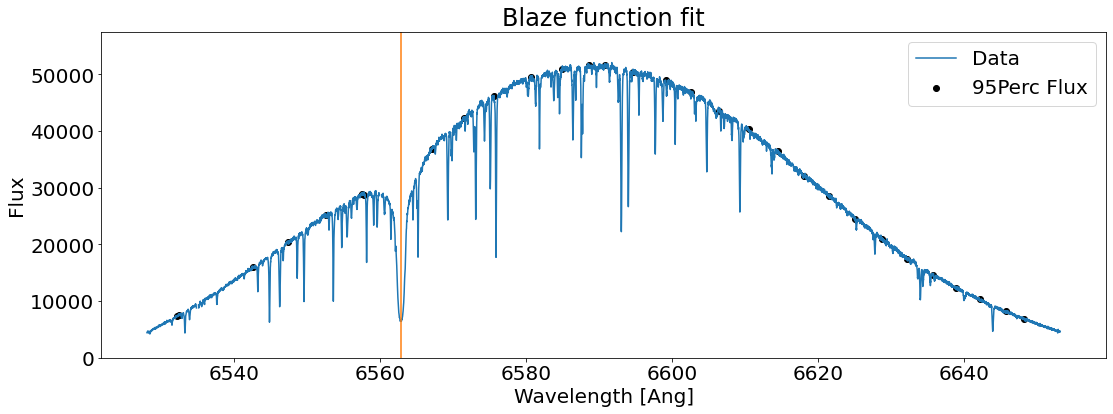

6532.198977527438 6648.187581731159 range 115.98860420372148


In [344]:
# Use APF-data-analysis to remove the blaze function.
bin=300
indices=[]

for i in np.arange(len(sci_flux_Ha)-bin,step=bin):
    flux_values=[]
    for j in np.arange(i,i+bin,step=1):
        value = sci_flux_Ha[j]
        flux_values = np.append(flux_values,value)
        
    flux_in_bin=np.percentile(flux_values,95)#Find 95% tile of flux to avoid cosmics
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(),key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i+index_in_bin
    indices = np.append(indices,index)

# Define deblazing arrays    
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values,sci_wave_Ha_rest[ind]) 
    fl_values = np.append(fl_values,sci_flux_Ha[ind])
    
# Perform the deblazing:
spl = splrep(wl_values,fl_values,s=2e6)
flux_fit = splev(sci_wave_Ha_rest,spl)
norm_Ha_flux = sci_flux_Ha/flux_fit

plt.plot(sci_wave_Ha_rest,sci_flux_Ha,label='Data')    
plt.scatter(wl_values,fl_values,color = 'black',label='95Perc Flux')
plt.plot([Halpha_wavelength,Halpha_wavelength],[0,1e6])
plt.title('Blaze function fit')
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Flux')
plt.ylim(0,np.median(fl_values)*2)
plt.legend()
plt.show()

#print(sci_flux_Ha)
print(min(wl_values),max(wl_values),'range',max(wl_values)-min(wl_values))

30 30


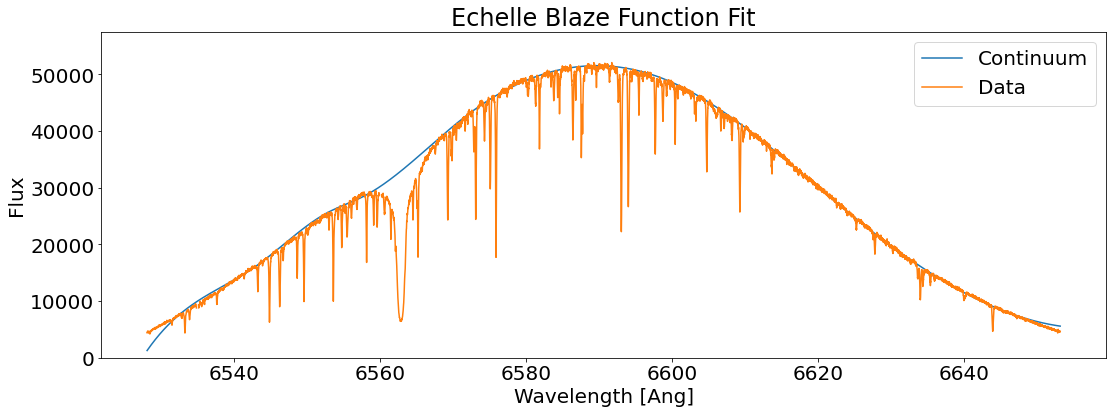

In [345]:
# Overplot the blaze function
plt.plot(sci_wave_Ha_rest,flux_fit,label='Continuum')
plt.plot(sci_wave_Ha_rest,sci_flux_Ha,label='Data')
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.ylim(0,np.median(fl_values)*2)
plt.legend()
print(len(wl_values),len(fl_values))

In [351]:
# Large cosmics are problematic. Replace with nearby median
# Need to mask out the line core.

norm_Ha_flux_no_nas = norm_Ha_flux[~np.isnan(norm_Ha_flux)]
thresh = 1.2 * np.median(norm_Ha_flux_no_nas) # 1.2 * median flux in cont sections
npix   = len(norm_Ha_flux)
for i,item in enumerate(fl_values):
    if i > 5 and i < npix: # beware of edges
        if item > thresh:
            norm_Ha_flux_no_nas[i] = np.median([norm_Ha_flux_no_nas[i-5],norm_Ha_flux_no_nas[i+5]]) # replace with median of surrounding pixels
print("Threshold:",thresh)

#norm_Ha_flux

Threshold: 1.18948762882004


Text(0, 0.5, 'Normalized Flux')

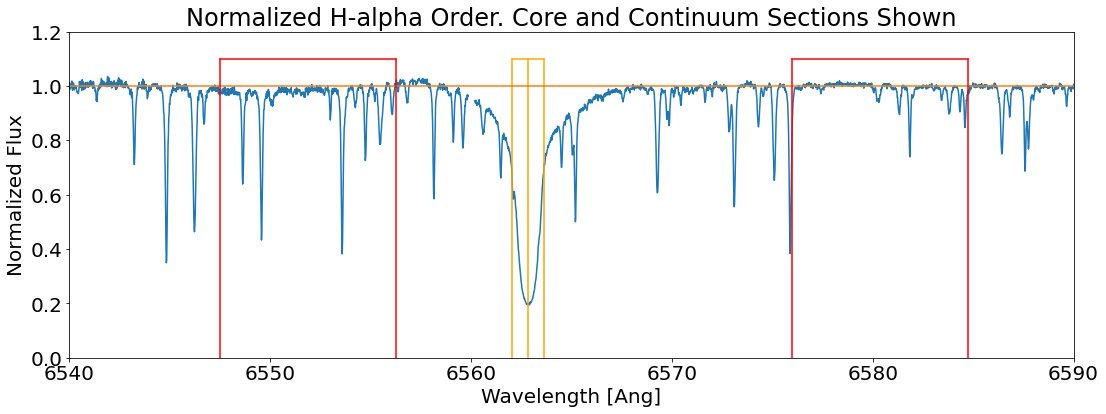

In [347]:
# Remove the blaze function and plot the normalized flux.
#  Overplot the H-alpha window and continuum windows.

plt.plot(sci_wave_Ha_rest,norm_Ha_flux)
plt.plot([Halpha_wavelength,Halpha_wavelength],[0,1.1],c='orange')
plt.plot([Hwid_v1a,Hwid_v1a],[0,1.1],c='orange')
plt.plot([Hwid_v1b,Hwid_v1b],[0,1.1],c='orange')
plt.plot([Hwid_v1a,Hwid_v1b],[1.1,1.1],c='orange')
plt.plot([6540,6600],[1,1])

plt.plot([lambda_c1a,lambda_c1b],[1.1,1.1],c='red')
plt.plot([lambda_c2a,lambda_c2b],[1.1,1.1],c='red')

plt.plot([lambda_c1a,lambda_c1a],[0,1.1],c='red')
plt.plot([lambda_c1b,lambda_c1b],[0,1.1],c='red')
plt.plot([lambda_c2a,lambda_c2a],[0,1.1],c='red')
plt.plot([lambda_c2b,lambda_c2b],[0,1.1],c='red')
plt.xlim([6540,6590])
plt.ylim(0.,1.2)
plt.title("Normalized H-alpha Order. Core and Continuum Sections Shown")
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Normalized Flux')


In [358]:
# Calculate the flux based on Kurster 2003 and Gomes da Silva 2011 as referenced in Robertson 2013

condition1 = (sci_wave_Ha_rest > Hwid_v1a) & (sci_wave_Ha_rest < Hwid_v1b)
condition2 = (sci_wave_Ha_rest > lambda_c1a) & (sci_wave_Ha_rest < lambda_c1b)
condition3 = (sci_wave_Ha_rest > lambda_c2a) & (sci_wave_Ha_rest < lambda_c2b)

flux_Halpha = np.sum(np.extract(sci_wave_Ha_rest,condition1))
flux_cont1  = np.sum(np.extract(sci_wave_Ha_rest,condition2))
flux_cont2  = np.sum(np.extract(sci_wave_Ha_rest,condition3))

I_Halpha = flux_Halpha / (flux_cont1 + flux_cont2) # K2003 uses the average flux of the cont sections. Not obvious that Roberston does this.
print(flux_Halpha, flux_cont1,flux_cont2,I_Halpha)

100 530 589 0.08936550491510277


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [ ]:
# View as code to see formatting easier.
# This is a copy from a recent NEID file from Tau Ceti.
# Each row in the table is a FITS_record object which looks like a (Python) tuple containing elements of heterogeneous data types.
# https://docs.astropy.org/en/stable/io/fits/index.html?highlight=astropy.fits
FITS_rec([('CaIIHK', 0.13903125, 0.00038854, '3968.470, 3933.664', 1.09 , 3901.07 ,  4001.07 , 20.   , 20.   , '157, 155', '17, 19', ''),
          ('HeI_1', 0.51696115, 0.00055735, '5875.62',        0.4  ,      5869.   ,  5881.   ,  5.   ,  5.   , '106','68', ''),
          ('HeI_2', 0.52152988, 0.00034242, '5875.62',        0.4  ,      5869.   ,  5881.   ,  5.   ,  5.   , '105','69', ''),
          ('NaI', 0.2447015 , 0.00016698, '5895.92, 5889.95', 0.5  ,      5805.   ,  6097.   , 10.   , 20.   , '107, 105, 102', '67, 69, 72', ''),
          ('Ha06_1', 0.13573731, 0.0002258 , '6562.808',      0.6  ,      6550.87 ,  6580.31 , 10.75 ,  8.75 , '95', '79', ''),
          ('Ha06_2', 0.10590783, 0.00012704, '6562.808',      0.6  ,      6550.87 ,  6580.31 , 10.75 ,  8.75 , '94', '80', ''),
          ('Ha16_1', 0.26031137, 0.00019586, '6562.808',      1.6  ,      6550.87 ,  6580.31 , 10.75 ,  8.75 , '95', '79', ''),
          ('Ha16_2', 0.20188273, 0.00010831, '6562.808',      1.6  ,      6550.87 ,  6580.31 , 10.75 ,  8.75 , '94', '80', ''),
          ('CaI_1', 0.63386398, 0.00087706, '6572.795',      0.34 ,       6550.87 ,  6580.31 , 10.75 ,  8.75 , '95', '79', ''),
          ('CaI_2', 0.47320735, 0.0003229 , '6572.795',      0.34 ,       6550.87 ,  6580.31 , 10.75 ,  8.75 , '94', '80', ''),
          ('CaIRT1', 0.25471684, 0.00017495, '8498.018',     0.851,       8492.   ,  8504.   ,  2.267,  2.27 , '73', '101', ''),
          ('CaIRT2', 0.18821686, 0.00016582, '8542.089',     0.855,       8534.966,  8550.637,  2.278,  2.282, '73', '101', ''),
          ('CaIRT3', 0.19138786, 0.0001677 , '8662.14',      0.867,       8654.916,  8669.363,  2.31 ,  2.314, '72', '102', ''),
          ('NaINIR', 0.69440281, 0.00039926, '8183.26, 8194.82', 0.5  ,   8141.   ,  8207.   ,  2.   ,  2.   , '76', '98', ''),
#          ('PaDelta', 0.45413014, 0.00105617, '10049.4', 0.5  , 10045.   , 10076.95 ,  5.   ,  5.9  , '62', '112', '')],
         dtype=(numpy.record, [  ('INDEX', 'S10'), ('VALUE', '>f8'), ('UNCERTAINTY', '>f8'), ('LINE_CENTER', 'S20') 
                               , ('LINE_WIDTH', '>f8'), ('REF_CENTER1', '>f8'), ('REF_CENTER2', '>f8'), ('REF_WIDTH1', '>f8')
                               , ('REF_WIDTH2', '>f8'), ('ORDER_USED', 'S13'), ('ORDER_INDEX', 'S13'), ('STATUS', 'S20')]))


In [16]:
# Use the same table structure as used in NEID

index_rows = [ 'CaIIHK', 'HeI_1',  'HeI_2', 'NaI' 
        ,'Ha06_1', 'Ha06_2', 'Ha16_1','Ha16_2'
        ,'CaI_1',  'CaI_2' , 'CaIRT1', 'CaIRT2'
        ,'CaIRT3', 'NaINIR']
        #,'PaDelta'] # not on KPF format

line_center_rows = ['3968.470, 3933.664','5875.62', '5875.62', '5895.92, 5889.95'
                   , '6562.808', '6562.808', '6562.808', '6562.808'
                   , '6572.795','6572.795', '8498.018','8542.089'
                   ,'8662.14','8183.26, 8194.82']    

line_width_rows = [ 1.09, 0.4, 0.4, 0.5
                   ,0.6,  0.6, 1.6, 1.6
                   ,0.34, 0.34,0.851,0.855
                   ,0.867,0.5]

ref_center1_rows = [ 3901.07,  5869.,   5869.,   5805.
                   , 6550.87,  6550.87, 6550.87, 6550.87
                   , 6550.87,  6550.87, 8492.,   8534.966
                   , 8654.916, 8141. ]

ref_center2_rows = [  4001.07, 5881.,   5881.,  6097.
                    , 6580.31, 6580.31, 6580.31,6580.31
                    , 6580.31, 6580.31, 8504,   8550.637
                    , 8669.363,8207.]

ref_width1_rows = [ 20.,5,5,10
                  , 10.75,10.75,10.75,10.75
                  ,10.75,10.75,2.267,2.278
                  ,2.31,2]
ref_width2_rows = [ 20.,5,5,20
                  , 8.75,8.75,8.75,8.75
                  , 8.75, 8.75,2.27,2.282
                  ,2.314,2]

order_used_rows = [ '157, 155','106','105','107, 105, 102'
                   ,'95','94','95','94'
                   ,'95','94','73','73'
                   ,'72','76' ]

order_index_rows = ['17','68','69','67, 69, 72'
                   ,'79','80','79','80'
                   ,'79','80','101','101'
                   ,'102','98',]
#Copy the constant values from NEID header


# These columns should work for NEID and KPF data. (they are copied from NEID data.)
c1 = Column(name='INDEX', format='10A', array=index_rows)
c2 = Column(name='VALUE', format='K' )
c3 = Column(name='UNCERTAINTY', format='A10')
c4 = Column(name="LINE_CENTER",format='A20',array=index_rows)
c5 = Column(name="LINE_WIDTH",format='K',array=line_width_rows)
c6 = Column(name="REF_CENTER1",format='K', array=ref_center1_rows)
c7 = Column(name="REF_CENTER2",format='K', array=ref_center2_rows)
c8 = Column(name="REF_WIDTH1",format='K',array=ref_width1_rows)
c9 = Column(name="REF_WIDTH2",format='K',array=ref_width2_rows)
c10 = Column(name="ORDER_USED",format='A13',array=order_used_rows)
c10 = Column(name="ORDER_INDEX",format='A13',array=order_index_rows)
c11 = Column(name="STATUS",format='A13')

In [17]:
# Create the BinTableHDU that will be put into an old NEID or KPF file. Based on Activity table from recen NEID obs.
a1 = np.array(['NGC1001', 'NGC1002', 'NGC1003'])
a2 = np.array([11.1, 12.3, 15.2])
col1 = fits.Column(name='target', format='20A', array=a1)
col2 = fits.Column(name='V_mag', format='E', array=a2)

#cols  = fits.ColDefs([c1,c2,c3])   # in progress
cols  = fits.ColDefs([col1,col2])  # Should look like this
 
# Create a new BinTable from the columns, overwrite the old one.
Activity_new = fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11],name='Activity')


with fits.open(TEST_DIR + in_file) as hdul2:
#    hdul2.info()
#    hdul2['ACTIVITY'] = tbhdu
    hdul2.pop('Activity')
    hdul2.append(Activity_new)
    
#hdul2.info()
hdul2['Activity'].data

FITS_rec([('CaIIHK', 0, '', 'CaIIHK', 1, 3901, 4001, 20, 20, '17', ''),
          ('HeI_1', 0, '', 'HeI_1', 0, 5869, 5881,  5,  5, '68', ''),
          ('HeI_2', 0, '', 'HeI_2', 0, 5869, 5881,  5,  5, '69', ''),
          ('NaI', 0, '', 'NaI', 0, 5805, 6097, 10, 20, '67, 69, 72', ''),
          ('Ha06_1', 0, '', 'Ha06_1', 0, 6550, 6580, 10,  8, '79', ''),
          ('Ha06_2', 0, '', 'Ha06_2', 0, 6550, 6580, 10,  8, '80', ''),
          ('Ha16_1', 0, '', 'Ha16_1', 1, 6550, 6580, 10,  8, '79', ''),
          ('Ha16_2', 0, '', 'Ha16_2', 1, 6550, 6580, 10,  8, '80', ''),
          ('CaI_1', 0, '', 'CaI_1', 0, 6550, 6580, 10,  8, '79', ''),
          ('CaI_2', 0, '', 'CaI_2', 0, 6550, 6580, 10,  8, '80', ''),
          ('CaIRT1', 0, '', 'CaIRT1', 0, 8492, 8504,  2,  2, '101', ''),
          ('CaIRT2', 0, '', 'CaIRT2', 0, 8534, 8550,  2,  2, '101', ''),
          ('CaIRT3', 0, '', 'CaIRT3', 0, 8654, 8669,  2,  2, '102', ''),
          ('NaINIR', 0, '', 'NaINIR', 0, 8141, 8207,  2,  2, '98', 

In [18]:
# Fill in the 

In [19]:
"""
A module for analysis tools focused on determining fluxes of spectral features.
"""

import warnings
from functools import wraps

import numpy as np
from astropy.nddata import StdDevUncertainty, VarianceUncertainty, InverseVariance

from .. import conf
from ..spectra import Spectrum1D
from ..manipulation import extract_region, LinearInterpolatedResampler
from .utils import computation_wrapper
import astropy.units as u
from astropy.stats import mad_std
from astropy.utils.exceptions import AstropyUserWarning


__all__ = ['line_flux', 'equivalent_width', 'is_continuum_below_threshold',
           'warn_continuum_below_threshold']


[docs]
def line_flux(spectrum, regions=None,
              mask_interpolation=LinearInterpolatedResampler):
    """
    Computes the integrated flux in a spectrum or region of a spectrum.

    Applies to the whole spectrum by default, but can be limited to a specific
    feature (like a spectral line) if a region is given.

    Parameters
    ----------
    spectrum : Spectrum1D
        The spectrum object over which the summed flux will be calculated.

    regions : `~specutils.SpectralRegion` or list of `~specutils.SpectralRegion`
        Region within the spectrum to calculate the gaussian sigma width. If
        regions is `None`, computation is performed over entire spectrum.

    mask_interpolation : ``None`` or `~specutils.manipulation.LinearInterpolatedResampler`
        Interpolator class used to fill up the gaps in the spectrum's flux
        array, when the spectrum mask is not None. If set to ``None``, the
        masked spectral bins are excised from the data without interpolation
        and the bin edges of the adjacent bins are extended to fill the gap.

    Returns
    -------
    flux : `~astropy.units.Quantity`
        Flux in the provided spectrum (or regions). Unit isthe ``spectrum``'s'
        ``flux`` unit times ``spectral_axis`` unit.

    Notes
    -----
    While the flux can be computed on any spectrum or region, it should be
    continuum-subtracted to compute actual line fluxes.
    """
    return computation_wrapper(_compute_line_flux, spectrum, regions,
                               mask_interpolation=mask_interpolation)



[docs]
def equivalent_width(spectrum, continuum=1, regions=None,
                     mask_interpolation=LinearInterpolatedResampler):
    """
    Computes the equivalent width of a region of the spectrum.

    Applies to the whole spectrum by default, but can be limited to a specific
    feature (like a spectral line) if a region is given.

    Parameters
    ----------
    spectrum : Spectrum1D
        The spectrum object overwhich the equivalent width will be calculated.

    regions: `~specutils.SpectralRegion` or list of `~specutils.SpectralRegion`
        Region within the spectrum to calculate the equivalent width. If
        regions is `None`, computation is performed over entire spectrum.

    continuum : ``1`` or `~astropy.units.Quantity`, optional
        Value to assume is the continuum level.  For the special value ``1``
        (without units), ``1`` in whatever the units of the ``spectrum.flux``
        will be assumed, otherwise units are required and must be the same as
        the ``spectrum.flux``.

    mask_interpolation : ``None`` or `~specutils.manipulation.LinearInterpolatedResampler`
        Interpolator class used to fill up the gaps in the spectrum's flux
        array after an excise operation to ensure the mask shape can always be
        applied when the spectrum mask is not None. If set to ``None``, the
        masked spectral bins are excised from the data without interpolation
        and the bin edges of the adjacent bins are extended to fill the gap.

    Returns
    -------
    ew : `~astropy.units.Quantity`
        Equivalent width calculation, in the same units as the ``spectrum``'s
        ``spectral_axis``.

    Notes
    -----
    To do a standard equivalent width measurement, the ``spectrum`` should be
    continuum-normalized to whatever ``continuum`` is before this function is
    called.

    """

    kwargs = dict(continuum=continuum)
    return computation_wrapper(_compute_equivalent_width, spectrum, regions,
                               mask_interpolation=mask_interpolation, **kwargs)



def _compute_line_flux(spectrum, regions=None,
                       mask_interpolation=LinearInterpolatedResampler):

    if regions is not None:
        calc_spectrum = extract_region(spectrum, regions)
    else:
        calc_spectrum = spectrum

    # Account for the existence of a mask.
    if hasattr(calc_spectrum, 'mask') and calc_spectrum.mask is not None:
        mask = calc_spectrum.mask
        new_spec = Spectrum1D(flux=calc_spectrum.flux[~mask],
                              spectral_axis=calc_spectrum.spectral_axis[~mask])

        if mask_interpolation is None:
            return _compute_line_flux(new_spec)
        else:
            interpolator = mask_interpolation(extrapolation_treatment='zero_fill')
            sp = interpolator(new_spec, calc_spectrum.spectral_axis)
            flux = sp.flux
    else:
        flux = calc_spectrum.flux

    dx = np.abs(np.diff(calc_spectrum.spectral_axis.bin_edges))
    line_flux = np.sum(flux * dx)

    line_flux.uncertainty = None

    if calc_spectrum.uncertainty is not None:
        # Can't handle masks via interpolation here, since interpolators
        # only work with the flux array.
        if isinstance(calc_spectrum.uncertainty, StdDevUncertainty):
            variance_q = calc_spectrum.uncertainty.quantity ** 2
        elif isinstance(calc_spectrum.uncertainty, VarianceUncertainty):
            variance_q = calc_spectrum.uncertainty.quantity
        elif isinstance(calc_spectrum.uncertainty, InverseVariance):
            variance_q = 1/calc_spectrum.uncertainty.quantity
        else:
            warnings.warn(f"Uncertainty type "
                          f"'{calc_spectrum.uncertainty.uncertainty_type}' "
                          f"was not recognized by line_flux. Proceeding "
                          f"without uncertainty in result.",
                          AstropyUserWarning)
            variance_q = None

        if variance_q is not None:
            line_flux.uncertainty = np.sqrt(
                np.sum(variance_q * dx**2))

    # TODO: we may want to consider converting to erg / cm^2 / sec by default
    return line_flux


def _compute_equivalent_width(spectrum, continuum=1, regions=None,
                              mask_interpolation=LinearInterpolatedResampler):
    if regions is not None:
        spectrum = extract_region(spectrum, regions)

    # Account for the existence of a mask.
    if hasattr(spectrum, 'mask') and spectrum.mask is not None:
        mask = spectrum.mask
        spectrum = Spectrum1D(
            flux=spectrum.flux[~mask],
            spectral_axis=spectrum.spectral_axis[~mask])

    # Calculate the continuum flux value
    continuum = u.Quantity(continuum, unit=spectrum.flux.unit)

    # If continuum is provided as a single scalar/quantity value, create an
    # array the same size as the processed spectrum. Otherwise, assume that the
    # continuum was provided as an array and use as-is.
    if continuum.size == 1:
        continuum = continuum * np.ones(spectrum.flux.size)

    cont_spec = Spectrum1D(flux=continuum,
                           spectral_axis=spectrum.spectral_axis)
    cont_flux = _compute_line_flux(cont_spec,
                                   mask_interpolation=mask_interpolation)
    line_flux = _compute_line_flux(spectrum,
                                   mask_interpolation=mask_interpolation)

    # Calculate equivalent width
    dx = np.abs(np.diff(spectrum.spectral_axis.bin_edges))
    ew = np.sum((1 - line_flux / cont_flux) * dx)

    return ew.to(spectrum.spectral_axis.unit)


[docs]
def is_continuum_below_threshold(spectrum, threshold=0.01):
    """
    Determine if the baseline of this spectrum is less than a threshold.
    I.e., an estimate of whether or not the continuum has been subtracted.

    If ``threshold`` is an `~astropy.units.Quantity` with flux units, this
    directly compares the median of the spectrum to the threshold.
    of the flux to the threshold.

    If the threshold is a float or dimensionless quantity then the spectrum's uncertainty will be
    used or an estimate of the uncertainty. If the uncertainty is present then the
    threshold is compared to the median of the flux divided by the
    uncertainty.  If the uncertainty is not present then the threshold
    is compared to the median of the flux divided by the
    `~astropy.stats.mad_std`.

    Parameters
    ----------
    spectrum : `~specutils.spectra.spectrum1d.Spectrum1D`
        The spectrum object over which the width will be calculated.

    threshold: float or `~astropy.units.Quantity`
        The tolerance on the quantification to confirm the continuum is
        near zero.

    Returns
    -------
    is_continuum_below_threshold: bool
        Return True if the continuum of the spectrum is below the threshold, False otherwise.

    """

    flux = spectrum.flux
    uncertainty = spectrum.uncertainty if hasattr(spectrum, 'uncertainty') else None

    # Apply the mask if it exists.
    if hasattr(spectrum, 'mask') and spectrum.mask is not None:
        flux = flux[~spectrum.mask]
        uncertainty = uncertainty[~spectrum.mask] if uncertainty else uncertainty

    # If the threshold has units then the assumption is that we want
    # to compare the median of the flux regardless of the
    # existence of the uncertainty.
    if hasattr(threshold, 'unit') and not threshold.unit == u.dimensionless_unscaled:
        return np.median(flux) < threshold

    # If threshold does not have a unit, ie it is not a quantity, then
    # we are going to calculate based on the S/N if the uncertainty
    # exists.
    if uncertainty and uncertainty.uncertainty_type != 'std':
        return np.median(flux / uncertainty.quantity) < threshold
    else:
        return np.median(flux) / mad_std(flux) < threshold



[docs]
def warn_continuum_below_threshold(threshold=0.01):
    """
    Decorator for methods that should warn if the baseline
    of the spectrum does not appear to be below a threshold.

    The ``check`` parameter is based on the
    `astropy configuration system <http://docs.astropy.org/en/stable/config/#adding-new-configuration-items>`_.
    Examples are on that page to show how to turn off this type of warning checking.
    """
    def actual_decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            if conf.do_continuum_function_check:
                spectrum = args[0]
                if not is_continuum_below_threshold(spectrum, threshold):
                    if hasattr(threshold, 'unit'):
                        levelorsnr = 'value'
                    else:
                        levelorsnr = 'signal-to-noise'

                    message = "Spectrum is not below the threshold {} {}. ".format(levelorsnr, threshold)
                    message += "This may indicate you have not continuum subtracted this spectrum (or that you have but it has high SNR features).\n\n"
                    message += ("""If you want to suppress this warning either type """
                                """'specutils.conf.do_continuum_function_check = False' or """
                                """see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items """
                                """for other ways to configure the warning.""")

                    warnings.warn(message, AstropyUserWarning)
            result = function(*args, **kwargs)
            return result
        return wrapper
    return actual_decorator

ValueError: attempted relative import beyond top-level package